# Bone-to-Diet Analysis of East African Mammals
#### Taran Rallings
#### August 1, 2017

### Preamble

The following is a machine learning analysis of the East African mammal bone data taken from the post-cranial bones ID book and dietary data taken from papers. It runs a few different machine learning algorithms on the data including linear regressions, decision trees, and random forest regressions. These are meant principally as tests of the framework not as final results. 

The main purpose of the code here is as a foundation. The functions and pipelines found below are intended to be modular and easy to expand upon. It should be fairly simple to make additions that do things like employ large neural networks, map to dirichlet parameters, or include additional mammals. I need to get deeper into the herbivome paper but it looks like there is a way to add herbivomes too.


#### Next Up
* decide proper scaling for linear bone measurements with mass changes
* add a dimension reduction (PCA or LDA) to the grid search
* transform the diet categories to dirichlet parameters and map directly to those


## Preparation
### Load the Data

In [13]:
import os # libarary lets you interact directly with the operating system
from six.moves import urllib # library lets you call some Py2 functions with Py3 names

In [14]:
# set path for loading bone-diet data
BONES_PATH = "datasets/"
FILE_NAME = "pcdiets_V2.csv"

In [15]:
import pandas as pd # library for handling data in data frames
pd.set_option('display.max_columns', 100)

# this function loads the bone-diet data from a .csv to a dataframe
def load_trait_data(trait_path, file_name):
    # bones_path should be a file path to the bones data
    # function returns a dataframe
    csv_path = os.path.join(trait_path, file_name)
    return pd.read_csv(csv_path)

In [16]:
bones = load_trait_data(BONES_PATH, FILE_NAME) # load the bone and diet data
bones.head() # take a look at the first few rows

,common_name,Order,Family,Genus,Species,astragalus,calcaneum_B,calcaneum_length_A,femur_distal_A,femur_distal_B,femur_length,femur_promixal_B,femur_proximal_A,fore_p1_iii,fore_p2_iii,fore_p3_iii,hind_p1_iii,hind_p2_iii,hind_p3_iii,humerus_distal_A,humerus_distal_B,humerus_length_C,humerus_promixal_B,humerus_proximal_A,mass_max_kg,mass_min_kg,metacarpal_A,metacarpal_B,metatarsal_C,metatarsal_D,metacarpal_overall,metatarsal_overall,patella_length,pelvis_A,pelvis_B,pelvis_C,pelvis_D,RU_length_T,RU_distal_A_T,RU_proximal_A,scapula_A,scapula_B,scapula_C,scapula_D,tibia_distal_A,tibia_distal_B,tibia_length (c),tibia_proximal_A,tibia_proximal_B,ulna_length (c),ulna_proximal_A,ulna_proximal_B,vertebrae_atlas_female_A ( or no sex),vertebrae_atlas_female_B ( or no sex),vertebrae_atlas_female_C ( or no sex),vertebrae_axis_female_A (or no sex),vertebrae_axis_female_B (or no sex),vertebrae_c3_female_A,vertebrae_c3_female_B,vertebrae_c3_female_C,vertebrae_c7_female_A,vertebrae_c7_female_B,vertebrae_c7_female_C,Fruit,Root,Leaf,Woody,Herbaceous
0,ELEPHANT,Proboscidea,Elephantidae,Loxodonta,africana,109.0,NaN,190.0,168.0,100.0,1000,126.0,270.0,80.0,40.0,NaN,70.0,32.0,NaN,117.0,90.5,835,114.0,178.0,6500,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,146.0,142.0,320.0,790.0,850.0,680.0,134.0,94.5,210.0,116.0,187.0,710.0,127.0,79.0,625,157.0,54.0,765.0,85.0,176.0,293.0,193.0,165.0,132.0,220.0,46.5,206.0,141.5,44.0,300.0,145.0,1,1,1,1,1
1,HIPPO,Artiodactyla,Hippopotamidae,Hippopotamus,amphibius,77.0,126.0,186.0,162.0,107.0,521,82.0,186.0,59.0,35.0,24.0,60.0,37.0,30.0,111.0,60.5,492,96.0,144.0,2633,1135.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,83.0,350.0,345.0,750.0,NaN,108.0,NaN,86.5,68.5,81.0,403.0,85.0,57.5,333,135.5,56.0,NaN,NaN,NaN,285.0,153.0,140.0,125.0,150.0,55.0,187.0,137.0,51.5,128.0,217.0,0,0,1,0,1
2,GIRAFFE,Artiodactyla,Giraffidae,Giraffa,camelopardalis,77.0,143.0,205.0,147.0,114.0,516,53.0,185.0,132.0,56.0,113.0,117.0,53.0,97.0,122.0,54.5,490,125.0,157.0,1180,1180.0,89.5,49.5,80.0,39.5,633.0,640.0,97.0,99.0,208.0,345.0,515.0,687.0,107.0,111.0,99.0,87.5,94.0,648.0,109.0,71.5,642,161.5,71.0,325.0,48.5,65.0,118.0,92.0,155.0,254.0,125.0,246.0,62.5,75.0,235.0,100.0,183.0,0,0,1,1,0
3,COLOBUS,Primates,Haplorhini,Colobus,guereza,25.5,NaN,36.5,31.5,16.5,201,14.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,23.5,10.0,148,148.0,20.5,15,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,47.0,49.5,154.0,136.0,13.5,12.5,22.0,11.5,17.5,79.5,22.0,16.0,186,32.0,22.5,153.0,10.5,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0
4,VERVET,Primates,Cercopithecidae,Chlorocebus,pygerythrus,16.0,NaN,26.5,19.5,9.5,143,8.5,23.5,NaN,NaN,NaN,NaN,NaN,NaN,14.5,7.5,121,13.0,13.5,8,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,32.0,27.0,100.5,119.0,13.5,9.5,15.5,10.5,14.5,69.5,13.0,9.5,135,19.5,13.0,133.0,8.5,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0


<function matplotlib.pyplot.show>

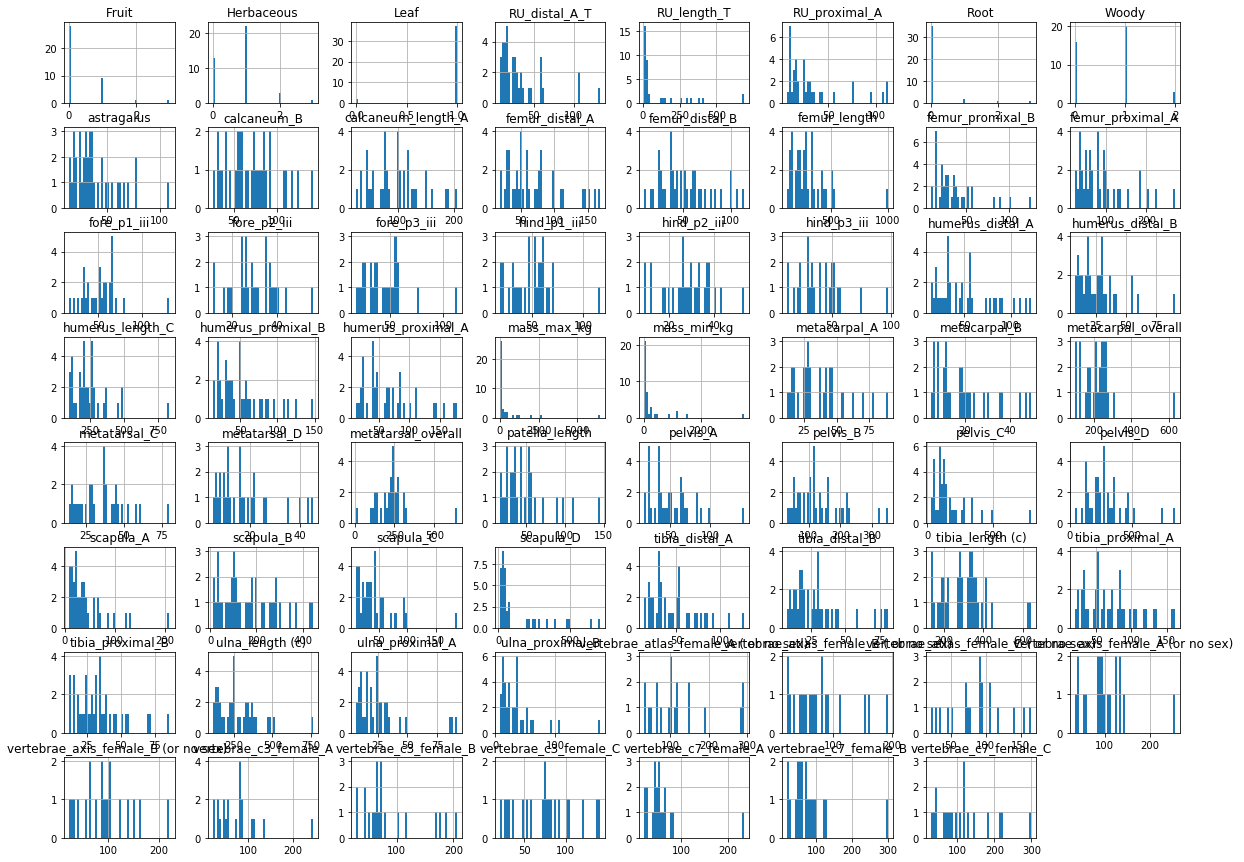

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt # import graphing library

bones.hist(figsize=(20,15), bins=50) # make histograms of the data columns
plt.show

### Preprocessing

In [18]:
import numpy as np # add library for multi dimensional arrays and a bunch of numerical operations

# this functions splits the data into testing and training sets
def split_train_test(data, test_ratio):
    # data should be a pandas dataframe, test_ratio should be a float [0-1]
    # function returns two data frames
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data)) # randomizes the indices list
    test_set_size = int(len(data) * test_ratio) # sets int length of test set
    test_indices = shuffled_indices[:test_set_size] # creates list of test set indices
    train_indices = shuffled_indices[test_set_size:] # creates list of train set indices
    return data.iloc[train_indices], data.iloc[test_indices] 

In [19]:
train_set, test_set = split_train_test(bones, 0.2) # create the training/testing sets with a 4/1 ratio
print(len(train_set), "train +", len(test_set), "test")

32 train + 7 test


In [20]:
bones = train_set.copy() # make a copy of the training set to use to avoid accidently changing original data

In [21]:
# seperating column names into lists that make it easier to select specific types of data 

just_bones = [
 'astragalus', 'calcaneum_B', 'calcaneum_length_A','femur_distal_A','femur_distal_B','femur_length',
 'femur_promixal_B','femur_proximal_A','fore_p1_iii','fore_p2_iii','fore_p3_iii','hind_p1_iii','hind_p2_iii',
 'hind_p3_iii','humerus_distal_A', 'humerus_distal_B', 'humerus_length_C', 'humerus_promixal_B', 'humerus_proximal_A',
 'metacarpal_A', 'metacarpal_B', 'metatarsal_C', 'metatarsal_D', 'metacarpal_overall', 'metatarsal_overall',
 'patella_length', 'pelvis_A', 'pelvis_B', 'pelvis_C', 'pelvis_D', 'RU_length_T', 'RU_distal_A_T', 'RU_proximal_A',
 'scapula_A', 'scapula_B', 'scapula_C', 'scapula_D', 'tibia_distal_A', 'tibia_distal_B', 'tibia_length (c)', 'tibia_proximal_A',
 'tibia_proximal_B', 'ulna_length (c) ', 'ulna_proximal_A', 'ulna_proximal_B', 'vertebrae_atlas_female_A ( or no sex)',
 'vertebrae_atlas_female_B ( or no sex)', 'vertebrae_atlas_female_C ( or no sex)', 'vertebrae_axis_female_A (or no sex) ',
 'vertebrae_axis_female_B (or no sex) ', 'vertebrae_c3_female_A', 'vertebrae_c3_female_B', 'vertebrae_c3_female_C',
 'vertebrae_c7_female_A', 'vertebrae_c7_female_B', 'vertebrae_c7_female_C',
]

just_diets = [
 'Fruit',
 'Root',
 'Leaf',
 'Woody',
 'Herbaceous'
]


In [22]:
# function to add mass data to column name list to avoid having to specify another huge llist
def make_list_with_mass(old_list, indivs = False):
    # old_list is a list of column names
    # returns column name list + the names of the mass columns
    new_list = [e for e in old_list]
    new_list.append('mass_min_kg')
    new_list.append('mass_max_kg')
    if indivs:
        new_list.append('mass_indiv_kg')
    return new_list

# function to remove diet column names from a list of column names
def remove_diets(old_list):
    # old list is a list of column names
    # returns a column name list - the names of diet columns
    new_list = old_list.copy()
    for d in just_diets:
        new_list.remove(d)
    return new_list


no_diets = remove_diets(list(bones)) # makes a list of every column name except for the diets
    
bones_and_mass = make_list_with_mass(just_bones) # makes a list of of bone and mass column names
indiv_bones_and_mass = make_list_with_mass(just_bones, indivs = True)

## Clean and Prepare the Data for Machine Learning Algorithms

In [23]:
# this creates a dataframe of just the diet data for each species entry, it provides a target for training the algorithms
diet_labels = train_set[just_diets].copy() 

### Custom Transformers

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

# class for adding a mean mass column and dividing all bone data by mean mass
mass_min_ix, mass_max_ix, mass_indiv_ix = 56, 57, 58,  # string variables for column numbers of mass 

# class for adding a mean mass column and dividing all bone data by mean mass
class MassModifier(BaseEstimator, TransformerMixin):
    def __init__(self, mass_transform = True, indiv_transform = False):
        self.mass_transform = mass_transform # mass_transform is a bool, True by default
        self.indiv_transform = indiv_transform # indiv_transform is a bool, False by default
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None): 
        # takes a np array, returns a np array with an mean mass value and optionally divides values by mean mass
        if not self.indiv_transform:
            mass_kg = (X[:,mass_max_ix] + X[:,mass_min_ix]) / 2 # creates a mean body mass value for a species
        else:
            mass_kg = X[:,mass_indiv_ix]
        if self.mass_transform: # if mean_transform was set to True
            X = X / mass_kg[0] # divide bone values by mean mass
            return np.c_[X, mass_kg]
        else:    
            return np.c_[X, mass_kg]

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# class for making numpy array out of pandas dataframe
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # takes a dataframe and returns its values as a np array
        return X[self.attribute_names].values

### Transformation Pipelines

In [26]:
from sklearn.pipeline import Pipeline # library for building pipelines
from sklearn.preprocessing import StandardScaler # library for scaling values +-[0-1]
from sklearn.preprocessing import Imputer # library for imputing missing values in the data


In [27]:
# building the data transformations into a pipeline. Each transformer runs a transform on the data and then passes
# the resulting array onto the next transformer
pipeline = Pipeline([
    ('selector', DataFrameSelector(bones_and_mass)), # selects the dataframe columns and makes into an array
    ('mass_transform', MassModifier()), # adds the mean mass column and divides all bone measurements by it
    ('imputer', Imputer(strategy='median')), # imputes missing array values and replaces with column medians
    ('std_scaler', StandardScaler()) # standardizes all of the values +-[0-1] for better ML goodness
])

In [28]:
bones_transformed = pipeline.fit_transform(bones) # runs the full transformer pipeline on the bones data

In [29]:
bones_transformed[0] # check to make sure the data looks good

array([ 0.43307293,  0.8029378 ,  0.6368969 ,  0.12209614,  0.58163155,
        0.17791525,  0.03088902,  0.19195179,  0.92069285,  0.85737455,
        0.81375962,  0.82636408,  1.0760747 ,  0.98513633,  0.15803981,
        0.1354667 ,  0.06252322, -0.20146874,  0.24245179,  0.65549645,
        0.21543259,  0.61666145,  0.41419065,  0.41705375,  0.39589536,
        0.27604832,  0.55294034,  0.04620978, -0.24971004,  0.18650191,
       -0.48574771, -0.26967165, -0.28710958, -0.10288251,  1.25402241,
       -0.20440481, -0.50422987,  0.21672423,  0.06404704,  0.48508898,
        0.25857024, -0.01698038,  0.87339929, -0.1081691 , -0.14754452,
       -0.17792323, -0.19346158, -0.07964668, -0.10080762, -0.04651252,
        0.48010778, -0.0980429 ,  1.08269293,  0.06368593, -0.04543727,
        0.19670795, -0.32836985, -0.32989823, -0.33106162])

In [30]:
bones_transformed.shape # check to make sure its the shape we expect

(32, 59)

## Select and Train the Model

### Training and Evalutating on the Training Set

In [31]:
from sklearn.linear_model import LinearRegression

# trying out a linear regression 

lin_reg = LinearRegression()
lin_reg.fit(bones_transformed, diet_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
# building a subsample of the data and results just to see what the outputs look like
some_data = bones.iloc[:5]
some_labels = diet_labels.iloc[:5]
some_data_transformed = pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_transformed)) # diet predictions of linear regression 

Predictions:	 [[ -1.11022302e-15   1.05471187e-15   1.00000000e+00   1.22124533e-15
    1.00000000e+00]
 [ -1.49880108e-15  -2.72004641e-15   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [ -4.05231404e-15  -7.32747196e-15   1.00000000e+00   1.00000000e+00
   -1.77635684e-15]
 [  1.00000000e+00  -2.27595720e-15   1.00000000e+00   1.00000000e+00
    1.00000000e+00]
 [  4.94049246e-15   4.30211422e-15   1.00000000e+00  -2.22044605e-15
    1.00000000e+00]]


In [33]:
print("Labels:\t", some_labels.values) # real diet labels of that data sample

Labels:	 [[0 0 1 0 1]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [1 0 1 1 1]
 [0 0 1 0 1]]


In [34]:
from sklearn.metrics import mean_squared_error

# checking the root mean squared error of the linear regression (very small... too small)
diet_predictions = lin_reg.predict(bones_transformed)
lin_mse = mean_squared_error(diet_labels, diet_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.8563173652310708e-15

In [35]:
from sklearn.tree import DecisionTreeRegressor

# trying out a decision tree regression

tree_reg = DecisionTreeRegressor()
tree_reg.fit(bones_transformed, diet_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [36]:
# checking the root mean squared error of the decision tree regression (also way to small)
diet_predictions = tree_reg.predict(bones_transformed)
tree_mse = mean_squared_error(diet_labels, diet_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Initial Thoughts 

Both regressions badly overfit the data. Below I will explore a number of approaches to avoid this problem

### Better Evaluation Using Cross Validation

Cross validation gives better assessments of accuracy by sequentially partitioning the data into validation and training sets. These partitions are rotated and employed multiple times to limit overfitting. 

In [37]:
from sklearn.model_selection import cross_val_score # library for getting cross validation results

# runs the cross validation on the decision tree regression, accurary assessed with negative mean squared error
scores = cross_val_score(tree_reg, bones_transformed, diet_labels, scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores) 

In [38]:
def display_scores(scores):
    # function takes cross validation scores and prints them out in a readable form
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [39]:
# root mean squared error scores for the decision tree regressor with cross validation
display_scores(rmse_scores) 

Scores: [ 0.38729833  0.97467943  1.39044357  0.63245553  0.68313005  0.36514837
  0.36514837  0.73029674  0.81649658  1.31656118]
Mean: 0.766165817132
Standard deviation: 0.350699216791


In [40]:
# root mean squared error scores for the linear regressor with cross validation
lin_scores = cross_val_score(lin_reg, bones_transformed, diet_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 1.04884116  3.27427177  4.56855247  1.4090165   4.02634     3.58496284
  1.71546527  1.00781115  0.72255199  0.95925576]
Mean: 2.23170689049
Standard deviation: 1.39057167541


In [41]:
from sklearn.ensemble import RandomForestRegressor # library for random forest regressors
# random forest runs a number of decisions trees and averages the results, less prone to overfitting than single trees
forest_reg = RandomForestRegressor()
forest_reg.fit(bones_transformed, diet_labels)

# root mean squared error scores for random forest regressor with cross validation
# results superior to decision tree and linear regressor
forest_scores = cross_val_score(forest_reg, bones_transformed, diet_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.4769696   0.64961527  1.25326241  0.59665736  0.42426407  0.29097537
  0.35213634  0.38557317  0.79288503  1.0214369 ]
Mean: 0.624377550382
Standard deviation: 0.297829942382


## Fine Tuning the Random Forest Regressor

#### Grid Search

Grid search automates the tuning of hyperparameters. Hyperparameters here are the number of trees in the forest (estimators), the number of data features used, and whether bootstrap is used. 

In [42]:
from sklearn.model_selection import GridSearchCV # library for gridsearch cross validation

all_features = list(range(1, 59)) # integer list of feature indices in the bones data

# the parameter grid is our "experimental" set up, the trials we want to perform and compare
param_grid = [
    {'n_estimators': [3, 10, 30,], 'max_features': all_features},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': all_features}
]

# build the random forest model and set up the grid search paramters
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [43]:
grid_search.fit(bones_transformed, diet_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]}, {'n_estimators':...4, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
grid_search.best_params_ # shows the best hyper parameter combination found in the grid search

{'max_features': 17, 'n_estimators': 10}

In [45]:
grid_search.best_estimator_ # shows the best estimator found in the grid search

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=17, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Analyze Best Models

In [46]:
# We can explore the grid search results to see which features were most important in the model
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, bones_and_mass), reverse=True)

[(0.085266902705655401, 'fore_p2_iii'),
 (0.062539880357446814, 'humerus_length_C'),
 (0.061026385582640327, 'scapula_B'),
 (0.053658028974049067, 'RU_proximal_A'),
 (0.050834891291263819, 'tibia_length (c)'),
 (0.046983927932398938, 'ulna_proximal_A'),
 (0.046598139990210466, 'pelvis_C'),
 (0.036664975477760826, 'mass_min_kg'),
 (0.035483801552757314, 'femur_distal_A'),
 (0.034380679198912308, 'scapula_A'),
 (0.03099445108059205, 'hind_p1_iii'),
 (0.030277977378554859, 'vertebrae_axis_female_A (or no sex) '),
 (0.029559293156508782, 'femur_length'),
 (0.028499891138689309, 'hind_p2_iii'),
 (0.027384859086589934, 'humerus_promixal_B'),
 (0.025325881017963282, 'ulna_length (c) '),
 (0.0234708520435222, 'metatarsal_overall'),
 (0.018074049384773486, 'femur_distal_B'),
 (0.018060916466106719, 'tibia_proximal_A'),
 (0.017141715169030826, 'metacarpal_B'),
 (0.016463388285660779, 'tibia_proximal_B'),
 (0.016016383181006257, 'patella_length'),
 (0.013907705154788272, 'metatarsal_C'),
 (0.0124

### Initial Thoughts

For the random forest regressor it seems the best model is a 10 tree forest employing the top 17 of these features. 

# Data Augmentation

In this section I am exploring options for making the most out of the tiny dataset. Instead of treating each species entry as an individual I am treating them as population means. With this in mind I randomly generate individuals of each species to create a new dataset of individuals. The algorithms can then trained on the, much larger, data set of individuals which should increase the model's ability to generalize. *fingers crossed*

Each individual has a body mass drawn from the min/max body mass entries for each species. The bone measurements are then altered in a manner proportionate to the body mass. 

In [47]:
# These are our functions used for the data augmentation process 

import random # library for prob distributions

mass_min_ix = bones[no_diets].columns.get_loc('mass_min_kg') # integer index of mass min column
mass_max_ix = bones[no_diets].columns.get_loc('mass_max_kg') # integer index of mass max column

# expands the bones dataset by breaking each spp into N individuals, randomly selecting a mass, and changing measures
def bones_augmentation(data_set, how_many, normal = False):
    # dataset is a dataframe, how_many is an int, normal is a bool (default is False)
    clone_army = populate_with_clones(data_set, how_many) # helper function that makes N clone versions of each spp entry
    individualize_the_clones(clone_army) # helper function that makes each of the N clones an individual
    return clone_army 
   

# creates N identical versions of each spp entry    
def populate_with_clones(data_set, new_indivs_per_species):
    # helper function for bones_augmentation
    # data set is a dataframe, new_indivs... is the number of individuals you want created for each species
    ds_copy = data_set.copy()  
    df = pd.DataFrame(columns=list(data_set)) # creates the new dataframe with same columns as original
    for i in range(len(ds_copy)): # loop through each species
        for j in range(new_indivs_per_species): # loop through each new individual and add to new dataframe
            df = df.append(data_set.iloc[i])
    df = df.reset_index(drop=True) # resent the indices so new dataframe doesn't have duplicates
    return df
                           

    # makes each clone species entry a unique individual by randomly selecting a mass and altering bone measures    
def individualize_the_clones(data_set, normal = False):
    # helper function for bones_augmentation
    # data_set is a data frame, normal is a bool
    # can draw mass from a uniform or normal distribution (uniform by default)
    for k in range(len(data_set)): # loop through each individual in the clone army
        # randomly select a mass between mass min and mass max
        species_mean_mass = (data_set.loc[k, 'mass_min_kg'] + data_set.loc[k, 'mass_max_kg']) / 2
        if normal == False: # if normal is false draw from a uniform distribution
            individual_mass = mass_uniform(data_set, k)
        else: # if normal is true draw from a normal distribution
            individual_mass = mass_normal(data_set, k, species_mean_mass)
        data_set.loc[k, 'mass_indiv_kg'] = individual_mass
        species_mean_mass = (data_set.loc[k, 'mass_min_kg'] + data_set.loc[k, 'mass_max_kg']) / 2 # set the mean of spp
        # find proportion of that mass wrt mean mass
        mass_proportion = individual_mass / species_mean_mass
        # multiply bone measures by proportion
        # I suspect the linear measures shoudl scale differently than mass (m^1/3?) but haven't implemented it yet
        for bone in just_bones:   
            data_set.ix[k, bone] *= mass_proportion                                
                                             
# this function constructs a normal distribution based on the mass from bones data and draws from it once
def mass_normal(data_set, species_index, species_mean_mass):
    # helper function for bones_augmentation
    # data_set is a dataframe, species_index is an int, species_mean_mass is a float
    mu =  species_mean_mass # set the distribution mean based on mean body mass
    # sets distance b/w mean and max as 2 std, not confident in this choice, will explore further
    sigma =  (data_set.loc[species_index, 'mass_max_kg'] - species_mean_mass) / 2 
    mass = np.random.normal(mu, sigma, 1) # makes one draw from the constructed distribution
    return mass
    
# this function constructs a uniform distribution based on min/max mass and draws from it once
def mass_uniform(data_set, species_index):
    min_mass = data_set.loc[species_index, 'mass_min_kg']
    max_mass = data_set.loc[species_index, 'mass_max_kg']
    mass = random.uniform(min_mass, max_mass) # make one draw from constructed distribution
    return mass

In [48]:
# run the bones_augmentation function to generate 100 individuals of each species from a normal mass distribution
augmented_bones = bones_augmentation(bones, 10, normal = True)
augmented_bones.head()

,common_name,Order,Family,Genus,Species,astragalus,calcaneum_B,calcaneum_length_A,femur_distal_A,femur_distal_B,femur_length,femur_promixal_B,femur_proximal_A,fore_p1_iii,fore_p2_iii,fore_p3_iii,hind_p1_iii,hind_p2_iii,hind_p3_iii,humerus_distal_A,humerus_distal_B,humerus_length_C,humerus_promixal_B,humerus_proximal_A,mass_max_kg,mass_min_kg,metacarpal_A,metacarpal_B,metatarsal_C,metatarsal_D,metacarpal_overall,metatarsal_overall,patella_length,pelvis_A,pelvis_B,pelvis_C,pelvis_D,RU_length_T,RU_distal_A_T,RU_proximal_A,scapula_A,scapula_B,scapula_C,scapula_D,tibia_distal_A,tibia_distal_B,tibia_length (c),tibia_proximal_A,tibia_proximal_B,ulna_length (c),ulna_proximal_A,ulna_proximal_B,vertebrae_atlas_female_A ( or no sex),vertebrae_atlas_female_B ( or no sex),vertebrae_atlas_female_C ( or no sex),vertebrae_axis_female_A (or no sex),vertebrae_axis_female_B (or no sex),vertebrae_c3_female_A,vertebrae_c3_female_B,vertebrae_c3_female_C,vertebrae_c7_female_A,vertebrae_c7_female_B,vertebrae_c7_female_C,Fruit,Root,Leaf,Woody,Herbaceous,mass_indiv_kg
0,ROAN,Artiodactyla,Bovidae,Hippotragus,equinus,48.760639,91.118366,126.088118,75.849883,68.461908,337.876753,37.924942,102.446596,69.939503,35.954815,54.178488,64.029122,36.939878,52.208361,56.148615,29.551903,265.967124,47.775576,80.775201,123.0,102.0,44.820386,20.686332,44.327854,20.686332,254.146363,265.967124,55.163552,64.521654,135.938752,136.923815,320.145612,25.119117,25.119117,25.119117,40.880132,296.504090,37.924942,52.700893,53.193425,32.014561,359.548149,81.267732,34.477220,392.055241,25.119117,31.522029,NaN,NaN,NaN,NaN,NaN,80.282669,71.909630,100.476469,54.671020,71.417098,118.207610,0.0,0.0,1.0,0.0,1.0,110.819635
1,ROAN,Artiodactyla,Bovidae,Hippotragus,equinus,45.562543,85.142126,117.818293,70.875067,63.971651,315.716208,35.437534,95.727363,65.352335,33.596623,50.625048,59.829602,34.517078,48.784137,52.465959,27.613662,248.522962,44.642088,75.477344,123.0,102.0,41.880721,19.329564,41.420494,19.329564,237.477497,248.522962,51.545503,60.289830,127.022847,127.943303,299.148010,23.471613,23.471613,23.471613,38.198900,277.057080,35.437534,49.244365,49.704592,29.914801,335.966227,75.937572,32.215940,366.341256,23.471613,29.454573,NaN,NaN,NaN,NaN,NaN,75.017116,67.193245,93.886452,51.085276,66.733018,110.454650,0.0,0.0,1.0,0.0,1.0,103.551234
2,ROAN,Artiodactyla,Bovidae,Hippotragus,equinus,49.933500,93.310075,129.120969,77.674333,70.108651,346.003847,38.837166,104.910787,71.621787,36.819651,55.481666,65.569242,37.828409,53.464151,57.499182,30.262727,272.364544,48.924742,82.718121,123.0,102.0,45.898469,21.183909,45.394091,21.183909,260.259453,272.364544,56.490424,66.073621,139.208545,140.217302,327.846210,25.723318,25.723318,25.723318,41.863439,303.636029,38.837166,53.968530,54.472909,32.784621,368.196513,83.222500,35.306515,401.485513,25.723318,32.280242,NaN,NaN,NaN,NaN,NaN,82.213742,73.639303,102.893272,55.986045,73.134924,121.050908,0.0,0.0,1.0,0.0,1.0,113.485227
3,ROAN,Artiodactyla,Bovidae,Hippotragus,equinus,52.643436,98.374098,136.128482,81.889790,73.913512,364.781792,40.944895,110.604392,75.508767,38.817888,58.492707,69.127745,39.881391,56.365700,60.619715,31.905113,287.146017,51.579933,87.207309,123.0,102.0,48.389421,22.333579,47.857670,22.333579,274.383972,287.146017,59.556211,69.659497,146.763520,147.827024,345.638724,27.119346,27.119346,27.119346,44.135406,320.114634,40.944895,56.897452,57.429203,34.563872,388.178875,87.739061,37.222632,423.274499,27.119346,34.032121,NaN,NaN,NaN,NaN,NaN,86.675557,77.635775,108.477384,59.024459,77.104023,127.620452,0.0,0.0,1.0,0.0,1.0,119.644174
4,ROAN,Artiodactyla,Bovidae,Hippotragus,equinus,45.573019,85.161703,117.845383,70.891363,63.986360,315.788800,35.445682,95.749374,65.367361,33.604348,50.636688,59.843359,34.525015,48.795354,52.478022,27.620012,248.580105,44.652352,75.494699,123.0,102.0,41.890351,19.334008,41.430018,19.334008,237.532100,248.580105,51.557355,60.303692,127.052054,127.972721,299.216793,23.477010,23.477010,23.477010,38.20

In [49]:
# make a dataframe of the diet labels for the augmented data
aug_diet_labels = augmented_bones[just_diets].copy()
aug_diet_labels.head()

,Fruit,Root,Leaf,Woody,Herbaceous
0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0


<function matplotlib.pyplot.show>

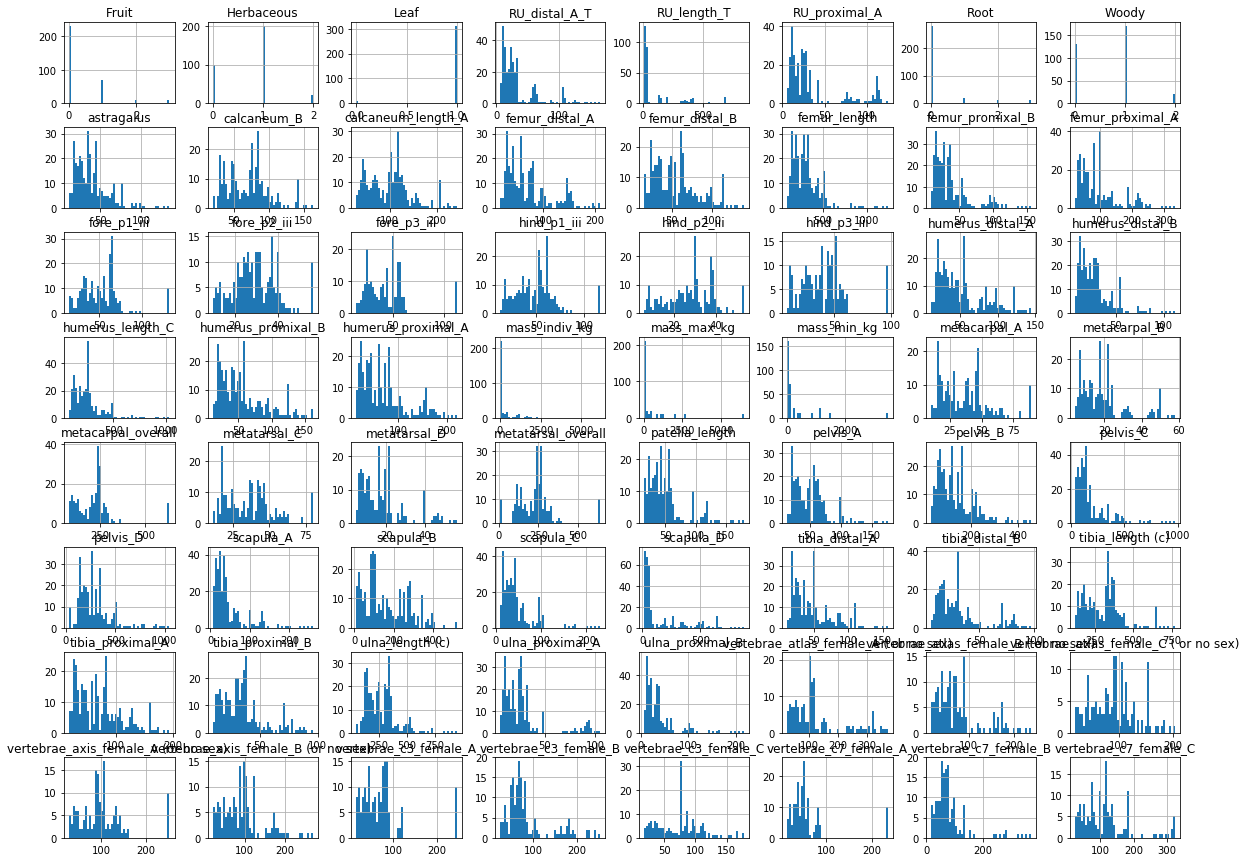

In [50]:
%matplotlib inline

# This is just an interesting aside to see how the values are distributed in the augmented data.

import matplotlib.pyplot as plt # import graphing library

augmented_bones.hist(figsize=(20,15), bins=50) # make histograms of the data columns
plt.show

In [51]:
# building the data transformations into a pipeline. Each transformer runs a transform on the data and then passes
# the resulting array onto the next transformer
aug_pipeline = Pipeline([
    ('selector', DataFrameSelector(indiv_bones_and_mass)), # selects the dataframe columns and makes into an array
    ('indiv_mass_transform', MassModifier(indiv_transform=True)), 
    ('imputer', Imputer(strategy='median')), # imputes missing array values and replaces with column medians
    ('std_scaler', StandardScaler()) # standardizes all of the values +-[0-1] for better ML goodness
])

In [52]:
# run the augmented dataset through the previously constructed pipeline
# 
augmented_bones_transformed = aug_pipeline.fit_transform(augmented_bones)

In [53]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

# runs a random forest regressor on the augmented (3200 individuals) data
forest_scores = cross_val_score(forest_reg, augmented_bones_transformed, aug_diet_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.51423487  0.45145598  0.61846584  0.46723923  0.64001953  0.29133314
  0.37658     0.32567238  0.80019529  0.65602972]
Mean: 0.514122599573
Standard deviation: 0.154565366782


So far it looks like the augmentation improves the results substantially. 

### Fine Tuning the Augmented Analysis

The following runs an almost identical grid search with the augmented data

In [54]:
all_features = list(range(1, 59))

param_grid = [
    {'n_estimators': [3, 10, 30,], 'max_features': all_features},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': all_features}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [55]:
grid_search.fit(augmented_bones_transformed, aug_diet_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]}, {'n_estimators':...4, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [56]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [58]:
# We can explore the grid search results to see which features were most important in the model
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, bones_and_mass), reverse=True)

[(0.069646619883747499, 'humerus_promixal_B'),
 (0.045308397481018663, 'ulna_proximal_A'),
 (0.045189278640555809, 'pelvis_C'),
 (0.037668325298700817, 'mass_min_kg'),
 (0.034596101593899767, 'hind_p2_iii'),
 (0.03240047275960263, 'pelvis_B'),
 (0.0304521880520769, 'RU_distal_A_T'),
 (0.030405322542030499, 'tibia_proximal_B'),
 (0.029059834088651627, 'metatarsal_overall'),
 (0.028085574267535895, 'femur_length'),
 (0.028033201632724151, 'humerus_distal_B'),
 (0.02785683805184308, 'patella_length'),
 (0.026664407614831281, 'calcaneum_B'),
 (0.026040928674778963, 'calcaneum_length_A'),
 (0.025796914274961412, 'humerus_distal_A'),
 (0.02443086879856839, 'tibia_proximal_A'),
 (0.024334177120623371, 'vertebrae_axis_female_A (or no sex) '),
 (0.024003689639595937, 'scapula_C'),
 (0.02097657432718596, 'humerus_proximal_A'),
 (0.019132032169533426, 'tibia_distal_A'),
 (0.016636161005736082, 'scapula_D'),
 (0.015784195418999718, 'humerus_length_C'),
 (0.015308777216359143, 'astragalus'),
 (0.01

### to do
corr_matrix = bones_tr.corr()
corr_matrix['mean_mass_kg'].sort_values(ascending=False)
some species only have a single mass value
def div_by_mass(data_set):
    for k in range(len(data_set)):
        mass = data_set[k, 'mass_indiv_kg']
        data_set[k, just_bones] = data_set[k, just_bones] / mass
    return data_set

## Change diets to Hempson 

In [124]:
def split_species_column(dataframe):
    #function takes a dataframe with a string column, splits data on seperator and returns two columns
    dataframe['Genus'] = dataframe.Species.str.split('\s+').str[0]
    dataframe['Species'] = dataframe.Species.str.split('\s+').str[1]
    return dataframe
    
def join_species_column(dataframe):
    #function takes a df with seperate species and genus columns and makes a single species column
    dataframe["Species_Full"] = dataframe.Genus.astype(str).str.cat(dataframe.Species.astype(str), sep=' ')
    return dataframe


def species_not_in_common(dataframe1, dataframe2):
    # investigate species in common between the two datasets
    bones_species = list(dataframe1.Species_Full)
    hempson_species = list(dataframe2.Species_Full)
    not_in_common = list(set(bones_species).difference(hempson_species))
    return not_in_common
    
def change_eland_names(dataframe):
    #changes tauratragus genus to tragelaphus
    dataframe[dataframe['Genus'] == "Taurotragus"] = "Tragelaphus"
    return dataframe

In [126]:
hempson_diets = load_trait_data(BONES_PATH, "hempson_traits.csv")

hempson_diets.head()

,Species,Body mass,Diet,Gut type,Herd size,Water dependence,HFT
0,Ammodorcas clarkei,27.2,BRW,Ruminant,Family,None,"Small, non-social, water independent browser/f..."
1,Cephalophus adersi,9.1,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f..."
2,Cephalophus callipygus,20.4,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f..."
3,Cephalophus dorsalis,20.6,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f..."
4,Cephalophus harveyi,11.5,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f..."


In [127]:
new_diets = split_species_column(hempson_diets)
new_diets = join_species_column(new_diets)
new_bones = change_eland_names(bones)
new_bones = join_species_column(new_bones)
species_not_in_common(new_bones, new_diets) #tragelaphus oryx = taurotragus oryx
                                            #tragelaphus derbians = taurotragus derbianus 

['Tragelaphus Tragelaphus',
 'Capra aegagrus',
 'Colobus guereza',
 'Alcelaphus buselaphus']

In [123]:
new_diets.head()

,Species,Body mass,Diet,Gut type,Herd size,Water dependence,HFT,Genus,Species_Full
0,clarkei,27.2,BRW,Ruminant,Family,None,"Small, non-social, water independent browser/f...",Ammodorcas,Ammodorcas clarkei
1,adersi,9.1,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f...",Cephalophus,Cephalophus adersi
2,callipygus,20.4,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f...",Cephalophus,Cephalophus callipygus
3,dorsalis,20.6,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f...",Cephalophus,Cephalophus dorsalis
4,harveyi,11.5,FRG,Ruminant,Solitary/pairs,None,"Small, non-social, water independent browser/f...",Cephalophus,Cephalophus harveyi


In [75]:
hempson_bones = pd.merge(bones, new_diets, on = 'Species_Full')